### 統計學習與深度學習
### Homework 5

請將IPYNB檔與IPYNB Export之HTML檔上傳至COOL作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。

這個作業將要練習影像分類的問題。影像分類是CNN模型的強項，我們的任務是區分照片中主角穿的上衣類型。這個問題在不同的情境下有不同的難度。在`Dive into Deep Learning`中有類似的問題，但是處理較"乾淨"的影像。這次作業的資料來自街拍影像，因此分類的困難度較高。

我們這次作業的任務，是依照照片中人物的上衣，區分以下類別:
* blazer
* cardigan
* coat
* jacket

下面列出這四個類別的範例訓練資料。

Label =  blazer


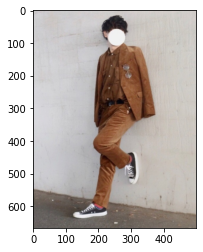

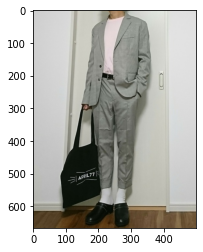

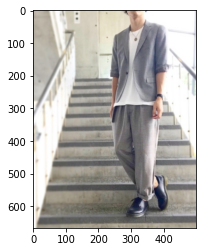

Label =  cardigan


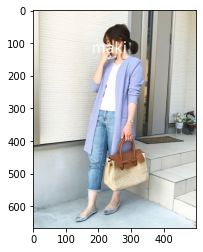

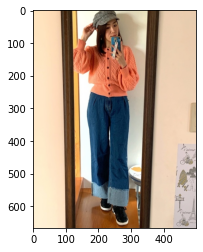

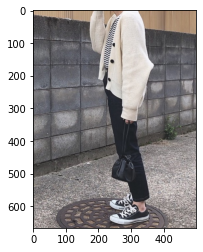

Label =  coat


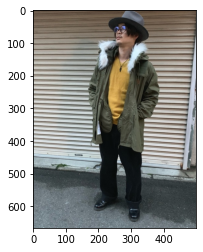

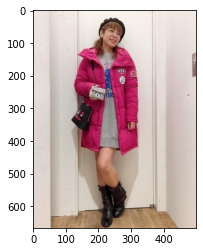

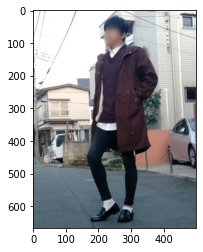

Label =  jacket


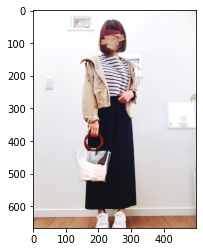

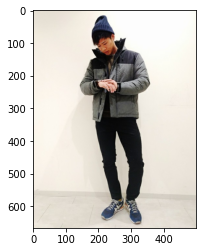

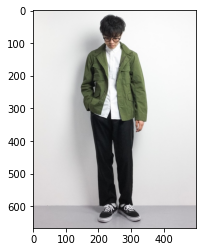

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random

random.seed(1223)
labels = ['blazer', 'cardigan', 'coat', 'jacket']
for i in range(4):
    print("Label = ", labels[i])
    basepath = os.path.join("photos/train", labels[i], "*.jpg")
    cand_fn = glob.glob(basepath)
    for afn in random.choices(cand_fn, k = 3):    
        img = Image.open(afn)
        plt.imshow(img)
        plt.show()

### 資料
資料在`photos`資料夾。已經區分好訓練(train)、校正(valid)、測試(test)資料。下一層則是依照圖片的標籤分資料夾存放，因此有四個資料夾，分別是blazer, cardigan, coat, jacket。一張圖片只會屬於一個類別。



### Q1
(5%) 列出train, valid, test的總照片數，以及各類別的照片數與比率。在還沒進行模型訓練與評估前，你認為各類別相對的準確率的大小關係為何?

In [13]:
labels = ['blazer', 'cardigan', 'coat', 'jacket']
def print_data_info(dataset_name):
    category_count = [0, 0, 0, 0] # blazer, cardigan, coat, jacket
    print(f"{dataset_name} photos:")
    for label in labels:
        # get the count of photos in different categories
        basepath = os.path.join(f"photos/{dataset_name}", label, "*.jpg")
        cand_fn = glob.glob(basepath)
        category_count[labels.index(label)] = len(cand_fn)
    # print the count of photos in different categories and the percentage of each category
    total_photo_count = sum(category_count)
    print(f"There are {total_photo_count} photos in total.")
    for i in range(4):
        print(f"For label {labels[i]}, there are {category_count[i]} photos, which is {category_count[i]/total_photo_count*100:.2f}% of the total.")


In [14]:
print_data_info("train")

train photos:
There are 1041 photos in total.
For label blazer, there are 97 photos, which is 9.32% of the total.
For label cardigan, there are 237 photos, which is 22.77% of the total.
For label coat, there are 296 photos, which is 28.43% of the total.
For label jacket, there are 411 photos, which is 39.48% of the total.


In [15]:
print_data_info("valid")

valid photos:
There are 105 photos in total.
For label blazer, there are 7 photos, which is 6.67% of the total.
For label cardigan, there are 36 photos, which is 34.29% of the total.
For label coat, there are 27 photos, which is 25.71% of the total.
For label jacket, there are 35 photos, which is 33.33% of the total.


In [16]:
print_data_info("test")

test photos:
There are 146 photos in total.
For label blazer, there are 9 photos, which is 6.16% of the total.
For label cardigan, there are 42 photos, which is 28.77% of the total.
For label coat, there are 43 photos, which is 29.45% of the total.
For label jacket, there are 52 photos, which is 35.62% of the total.


#### Discussion
Generally, we expect more data contributes to higher accuracy.  
And in training set, we can see that the photo count order is blazer > coat > cardigan > jacket.  
So **we expect the accuracy order is `blazer > coat > cardigan > jacket`**.

### Q2
(35%) 使用Resnet50建構圖片分類模型。將最後一層的Fully Connected Layer輸出維度改成4以符合本題任務需求。除了最後一層以外，使用torchvision提供的pretrained weights (`torchvision.models.resnet50(pretrained=True)`)初始化模型權重。使用train資料訓練模型，以valid資料決定Early Stopping的Epoch。Early Stopping的Patient參數設為20 Epochs。Batch size設為32。每一個Epoch計算一次Valid Loss，並記錄Valid Loss最低的模型。模型訓練最多200個Epochs。使用最佳模型在test資料計算模型Accuracy, Confusion Matrix, 與Per-class Accuracy。你應該要考慮SGD與ADAM兩種最佳化演算法。調整超參數以達到最好的Valid Loss。

由於圖片的解析度較高，模型訓練前須將解析度調整(Resize)成較短邊為256像素的照片，然後隨機取大小為224x224的影像。接著隨機水平翻轉(Horizontal Flip)、隨機旋轉-20度到20度，並依照Pretrained ResNet的要求調整RGB的均數與標準差。
測試資料(Valid and Test)亦須先將解析度調整(Resize)成較短邊為256像素的照片，然後取圖片中心224x224的影像。

得到Per-Class Accuracy之後，請討論與Q1預期的差異與可能原因。

提示: 
* Pytorch Resnet pretrained model的說明請見 <https://pytorch.org/hub/pytorch_vision_resnet/>
* 本題的Test Accuracy應高於78%。

### Q3
(30%) 使用Resnet50建構圖片分類模型。將最後一層的Fully Connected Layer輸出維度改成4以符合本題任務需求。除了最後一層以外，使用torchvision提供的pretrained weights (`torchvision.models.resnet50(pretrained=True)`)初始化模型權重。模型訓練時固定除了最後一層以外的其他權重。也就是說，模型訓練只會調整最後一層Fully Connected Layer。圖片前處理與前題一致。

使用train訓練模型，以valid決定early stopping的epoch。Early stopping的patient參數為20 epochs。Batch size設為32。紀錄valid loss最低的模型，並在test中計算模型Accuracy, Confusion Matrix, 與Per-class Accuracy。你應該要考慮SGD與ADAM兩種最佳化演算法。調整超參數以達到最好的valid loss。

### Q4
(20%) 使用Resnet50建構圖片分類模型。將最後一層的fully connected layer輸出維度改成4以符合本題任務需求。圖片前處理與前題一致。不使用預訓練權重初始化模型。使用train訓練模型，以valid決定early stopping的epoch。Early stopping的patient參數為20 epochs。Batch size設為32。紀錄valid loss最低的模型，並在test中計算模型Accuracy, Confusion Matrix, 與Per-class Accuracy。你應該要考慮SGD與ADAM兩種最佳化演算法。調整超參數以達到最好的valid loss。

### Q5
(10%) 統整併討論Q2-Q4的預測能力。說明你的觀察。